## Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as py
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import cufflinks as cf
from plotly.offline import iplot
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
py.offline.init_notebook_mode(connected=True)
cf.go_offline()

## Loading the dataset

In [3]:
df = pd.read_csv('Womens Clothing E-Commerce Reviews.csv')

In [4]:
df.head(3)

Unnamed: 0  Clothing ID  Age                    Title  \
0           0          767   33                      NaN   
1           1         1080   34                      NaN   
2           2         1077   60  Some major design flaws   

                                         Review Text  Rating  Recommended IND  \
0  Absolutely wonderful - silky and sexy and comf...       4                1   
1  Love this dress!  it's sooo pretty.  i happene...       5                1   
2  I had such high hopes for this dress and reall...       3                0   

   Positive Feedback Count Division Name Department Name Class Name  
0                        0     Initmates        Intimate  Intimates  
1                        4       General         Dresses    Dresses  
2                        0       General         Dresses    Dresses

In [5]:
df.shape

(23486, 11)

<b> The dataset has 23,486 records and 8 columns. </b>

In [6]:
# Dropping unwanted columns

df.drop(['Unnamed: 0', 'Clothing ID', 'Title'], axis=1, inplace=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Age                      23486 non-null  int64 
 1   Review Text              22641 non-null  object
 2   Rating                   23486 non-null  int64 
 3   Recommended IND          23486 non-null  int64 
 4   Positive Feedback Count  23486 non-null  int64 
 5   Division Name            23472 non-null  object
 6   Department Name          23472 non-null  object
 7   Class Name               23472 non-null  object
dtypes: int64(4), object(4)
memory usage: 1.4+ MB


<b> The dataset has 4 integer and 4 object columns. </b>

In [8]:
# Checking for null values

df.isnull().sum()

Age                          0
Review Text                845
Rating                       0
Recommended IND              0
Positive Feedback Count      0
Division Name               14
Department Name             14
Class Name                  14
dtype: int64

In [9]:
# Dropping records having null values

df.dropna(inplace=True)

In [10]:
# Checking if null values are removed

df.isnull().sum()

Age                        0
Review Text                0
Rating                     0
Recommended IND            0
Positive Feedback Count    0
Division Name              0
Department Name            0
Class Name                 0
dtype: int64

In [11]:
# Checking if any duplicate records are present

duplicate=df[df.duplicated()] 
duplicate

Age                                        Review Text  Rating  \
13354   26  Perfect fit and i've gotten so many compliment...       5   
14275   43  I bought this shirt at the store and after goi...       5   
21888   37  Love, love these jeans. being short they come ...       5   

       Recommended IND  Positive Feedback Count   Division Name  \
13354                1                        0       Initmates   
14275                1                        0  General Petite   
21888                1                        0         General   

      Department Name Class Name  
13354        Intimate       Swim  
14275            Tops      Knits  
21888         Bottoms      Jeans

<b> There are 3 duplicate records. </b>

In [12]:
# Removing duplicate records

df.drop_duplicates(inplace=True)

In [13]:
# Again check if any duplicate records are left

duplicate = df[df.duplicated()] 
duplicate

Empty DataFrame
Columns: [Age, Review Text, Rating, Recommended IND, Positive Feedback Count, Division Name, Department Name, Class Name]
Index: []

<b> Hence, all duplicate records are removed. </b>

In [14]:
df.describe()

Age        Rating  Recommended IND  Positive Feedback Count
count  22625.000000  22625.000000     22625.000000             22625.000000
mean      43.283934      4.182983         0.818740                 2.632133
std       12.328387      1.115946         0.385242                 5.787824
min       18.000000      1.000000         0.000000                 0.000000
25%       34.000000      4.000000         1.000000                 0.000000
50%       41.000000      5.000000         1.000000                 1.000000
75%       52.000000      5.000000         1.000000                 3.000000
max       99.000000      5.000000         1.000000               122.000000

In [15]:
df.describe(include='object')

Review Text Division Name  \
count                                               22625         22625   
unique                                              22621             3   
top     I purchased this and another eva franco dress ...       General   
freq                                                    2         13364   

       Department Name Class Name  
count            22625      22625  
unique               6         20  
top               Tops    Dresses  
freq             10047       6145

In [16]:
# Renaming columns

df.rename(columns={'Review Text':'Review', 
                   'Recommended IND':'Recommended', 
                   'Positive Feedback Count':'PositiveFeedback', 
                   'Division Name':'Division', 'Department Name':'Department', 
                   'Class Name':'Class'}, inplace=True)

## Text Preprocessing

In [17]:
# Expanding contractions

# Dictionary of English Contractions
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text)

# Expanding Contractions in the title, text
df['Review'] = df['Review'].apply(lambda x:expand_contractions(x))

In [18]:
# from nltk.stem.porter import PorterStemmer
# ps = PorterStemmer()
# corpus = []
# for i in range(0, len(df)):
#     print(i)
#     review = re.sub('[^a-zA-Z]', ' ', df['Review'][i])
#     review = review.lower()
#     review = review.split()
    
#     review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
#     review = ' '.join(review)
#     corpus.append(review)

In [19]:
df['polarity'] = df['Review'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['ReviewLen'] = df['Review'].apply(lambda x: len(x))
df['WordCount'] = df['Review'].apply(lambda x: len(x.split()))

In [20]:
# Polarity Distribution

df['polarity'].iplot(kind='hist', xTitle='Polarity', yTitle='Count', title='Distribution of Polarity')

In [21]:
# Distribution of Division

px.histogram(df, x=df['Division'], title='Count of Division')

In [22]:
# Distribution of Department

px.histogram(df, x=df['Department'], title='Count of Department')

In [23]:
# Distribution of Class

px.histogram(df, x=df['Class'], title='Count of Class')

<b> Most clothes belong to General division, Tops department and are Dresses or Knits. </b>

In [24]:
# Distribution of Rating and Age

px.histogram(df, x='Age', color='Rating', barmode='stack', title='Distribution of Rating and Age')

<b> People in their 30s are more likely to give rating. </b>

In [25]:
# Distribution of Review Length

df['ReviewLen'].iplot(kind='hist', bins=50, xTitle='Review Length', yTitle='Count', title='Distribution of Review Length')

<b> Most reviews have 200-300 length. </b>

In [26]:
# Distribution of Word count

df['WordCount'].iplot(kind='hist', bins=50, xTitle='Word count', yTitle='Count', title='Distribution of Word count')

<b> Most reviews have 30-40 words. </b>

In [27]:
df_pos = df.groupby('Recommended')['PositiveFeedback'].sum()
df_pos

Recommended
0    14114
1    45438
Name: PositiveFeedback, dtype: int64

<b> 45,438 customers who gave a positive review recommend the product whereas 14,114 customers who gave review didn't recommend it. </b>

In [28]:
df_rat = df.groupby('Recommended')['Rating'].mean()
df_rat

Recommended
0    2.303341
1    4.599115
Name: Rating, dtype: float64

<b> The mean rating for products which were recommended is 4.59 and for products which weren't recommended is 2.30. </b>

In [29]:
df_ratp = df.groupby('Rating')['PositiveFeedback'].sum()
df_ratp

Rating
1     2913
2     5205
3     9030
4    12213
5    30191
Name: PositiveFeedback, dtype: int64

<b> Maximum positive feedback is for products with rating 4 followed by products with rating 5. </b>

## N-Gram analysis before removing stopwords

### 1. Unigram

In [30]:
def get_top_n_words(x, n):
    vec = CountVectorizer().fit(x)
    bow = vec.transform(x)
    sum_words = bow.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x:x[1], reverse=True)
    return words_freq[:n]

In [31]:
# Unigram

words = get_top_n_words(df['Review'], 20)

df_uni = pd.DataFrame(words, columns=['Unigram', 'Frequency'])
df_uni = df_uni.set_index('Unigram')
df_uni.iplot(kind='bar', xTitle='Unigram', yTitle='Count', title='Top 20 Unigram Words')

### 2. Bigram

In [32]:
def get_top_nwords(x, n, i):
    vec = CountVectorizer(ngram_range=(i,i)).fit(x)
    bow = vec.transform(x)
    sum_words = bow.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x:x[1], reverse=True)
    return words_freq[:n]

In [33]:
# Bigram

words = get_top_nwords(df['Review'], 20, 2) 

df_bi = pd.DataFrame(words, columns=['Bigram', 'Frequency'])
df_bi = df_bi.set_index('Bigram')
df_bi.iplot(kind='bar', xTitle='Bigram', yTitle='Count', title='Top 20 Bigram Words')

### 3. Trigram

In [34]:
words = get_top_nwords(df['Review'], 20, 3) 

df_tri = pd.DataFrame(words, columns=['Trigram', 'Frequency'])
df_tri = df_tri.set_index('Trigram')
df_tri.iplot(kind='bar', xTitle='Trigram', yTitle='Count', title='Top 20 Trigram Words')

In [35]:
# Cleaning Review column

# Converting text to lowercase
df['Review'] = df['Review'].apply(lambda x:x.lower())

# Removing digits and words containing digits
df['Review'] = df['Review'].apply(lambda x: re.sub('\w*\d\w*','', x))

# Removing punctuations
df['Review'] = df['Review'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

# Removing extra spaces
df['Review'] = df['Review'].apply(lambda x: re.sub(' +',' ',x))

In [36]:
# Applying lemmatization and removing stopwords

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    rev = [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text) if w not in stopwords.words('english')]
    rev = ' '.join(rev)
    return rev

df['Review'] = df.Review.apply(lemmatize_text)

## N-Gram analysis after removing stopwords

### 1. Unigram

In [37]:
words = get_top_n_words(df['Review'], 20)

df_uni = pd.DataFrame(words, columns=['Unigram', 'Frequency'])
df_uni = df_uni.set_index('Unigram')
df_uni.iplot(kind='bar', xTitle='Unigram', yTitle='Count', title='Top 20 Unigram Words')

### 2. Bigram

In [38]:
# Bigram

words = get_top_nwords(df['Review'], 20, 2) 

df_bi = pd.DataFrame(words, columns=['Bigram', 'Frequency'])
df_bi = df_bi.set_index('Bigram')
df_bi.iplot(kind='bar', xTitle='Bigram', yTitle='Count', title='Top 20 Bigram Words')

### 3. Trigram

In [39]:
words = get_top_nwords(df['Review'], 20, 3) 

df_tri = pd.DataFrame(words, columns=['Trigram', 'Frequency'])
df_tri = df_tri.set_index('Trigram')
df_tri.iplot(kind='bar', xTitle='Trigram', yTitle='Count', title='Top 20 Trigram Words')

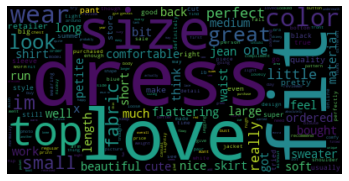

In [45]:
# Wordcloud of Review in Recommended product

# Cleaned dataframe of Recommended
df_true = df[df.Recommended == 1]

text_true = " ".join(txt for txt in df_true['Review'])

text_cloud = WordCloud(collocations=False, background_color='black').generate(text_true)
plt.axis("off")
plt.imshow(text_cloud, interpolation='bilinear')

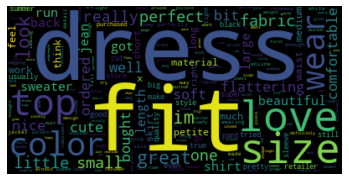

In [46]:
# Wordcloud of Review in not Recommended product

# Cleaned dataframe of Recommended
df_false = df[df.Recommended == 0]

text_true = " ".join(txt for txt in df_true['Review'])

text_cloud = WordCloud(collocations=False, background_color='black').generate(text_true)
plt.axis("off")
plt.imshow(text_cloud, interpolation='bilinear')

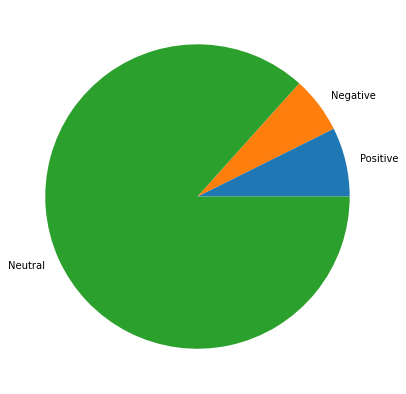

In [47]:
# Bar plot of polarity

negative = (len(df.loc[df.polarity < 0, ['Review']].values)/len(df))*100
positive = (len(df.loc[df.polarity > 0.5, ['Review']].values)/len(df))*100
neutral = len(df.loc[df.polarity >0 ,['Review']].values) - len(df.loc[df.polarity >0.5 ,['Review']].values)
neutral = neutral/len(df)*100

plt.figure(figsize =(10, 7)) 
plt.pie([positive,negative,neutral], labels = ['Positive','Negative','Neutral']) 
plt.show()

In [48]:
# Reviews with positive polarity

pos = df.loc[df.polarity == 1,['Review']].sample(3).values
for i in pos:
    print(i)

['daughter one wore everythingi ended getting one myselfit perfect weight']
['looking sweater like year look great itch cannot wait fall wear']
['flowing perfect hide flawsi adore']


In [49]:
# Reviews with negative polarity

neg = df.loc[df.polarity < 0,['Review']].sample(3).values
for i in neg:
    print(i)

['dress style delicate balance design beauty material']
['bought mustard color salmon color problem general fading used natural mild stain remover biokleen pant ruined one faded sprayed permanent water mark cold wash line dried bummer pant every day wearable washable']
['whatever happened sizing pretty print color enough fabric top also unlined huge issue wore cami arm gaping thankfully tried make work wide belt get tucked side lb got small gone even size smaller']


In [50]:
# Reviews with neutral polarity

neu = df.loc[df.polarity == 0,['Review']].sample(3).values
for i in neu:
    print(i)

['flattering poncho pair well legging skinny jean booty']
['although highest quality clothing ive ever received retailer still comfy']
['like extra detail neck back versatile wear everywhere']


In [51]:
# Distribution of Sentiment Polarity based on Recommendation

x1 = df[df['Recommended']==1]['polarity']
x0 = df[df['Recommended']==0]['polarity']

trace1 = go.Histogram(x=x0, name='Not Recommended', opacity=0.6)
trace0 = go.Histogram(x=x1, name='Recommended', opacity=0.8)

data = [trace0,trace1]
layout = go.Layout(barmode='overlay', title='Distribution of Sentiment Polarity of Reviews Based On The Recommendation ')
fig = go.Figure(data=data,layout=layout)
fig.show()

In [52]:
# Distribution of Sentiment Polarity based on Rating

r1 = df[df['Rating'] == 1]['polarity']
r2 = df[df['Rating'] == 2]['polarity']
r3 = df[df['Rating'] == 3]['polarity']
r4 = df[df['Rating'] == 4]['polarity']
r5 = df[df['Rating'] == 5]['polarity']

rat1 = go.Histogram(x=r1, name='1', opacity=0.5)
rat2 = go.Histogram(x=r2, name='2', opacity=0.6)
rat3 = go.Histogram(x=r3, name='3', opacity=0.7)
rat4 = go.Histogram(x=r4, name='4', opacity=0.8)
rat5 = go.Histogram(x=r5, name='5', opacity=0.9)

data = [rat1, rat2, rat3, rat4, rat5]
layout = go.Layout(barmode='overlay', title='Distribution of Sentiment Polarity of Reviews Based On The Rating')
fig = go.Figure(data=data, layout=layout)
fig.show()